# Using Design of Experiments (DoE) with Flow Chemistry

What follows is the notebook that you will use to analyse your results. Use the arrow keys to move up and down and press shift-enter on each box to run it (it has run if you see `In [1]` on the left hand side). Follow the instructions in here. 

Watch this video explainer first [[!!]]

If you have problems my office is [[!!]] and my office hours are [[!!]]. Or on zoom...

Do not worry too much about understanding how the python functions work, instead focus on what they do. (However, if you are a programmer, the functions are in doenut.py). 

In [1]:
# first we import some useful libraries
import numpy as np
import pandas as pd
import random
import doenut
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

In this experiment you will investigate the S$_{\mathrm{N}}$Ar reaction of 2,4-difluoronitrobenzene with pyrrolidine. This reaction can substitute one or both of the fluorine atoms of the starting material with pyrrolidine, and the aim of the experiment is to investigate how changing the reaction conditions varies the distribution of the three products.

The desired product is the ortho-substituted molecule, the para and di-substituted products are impurities. 

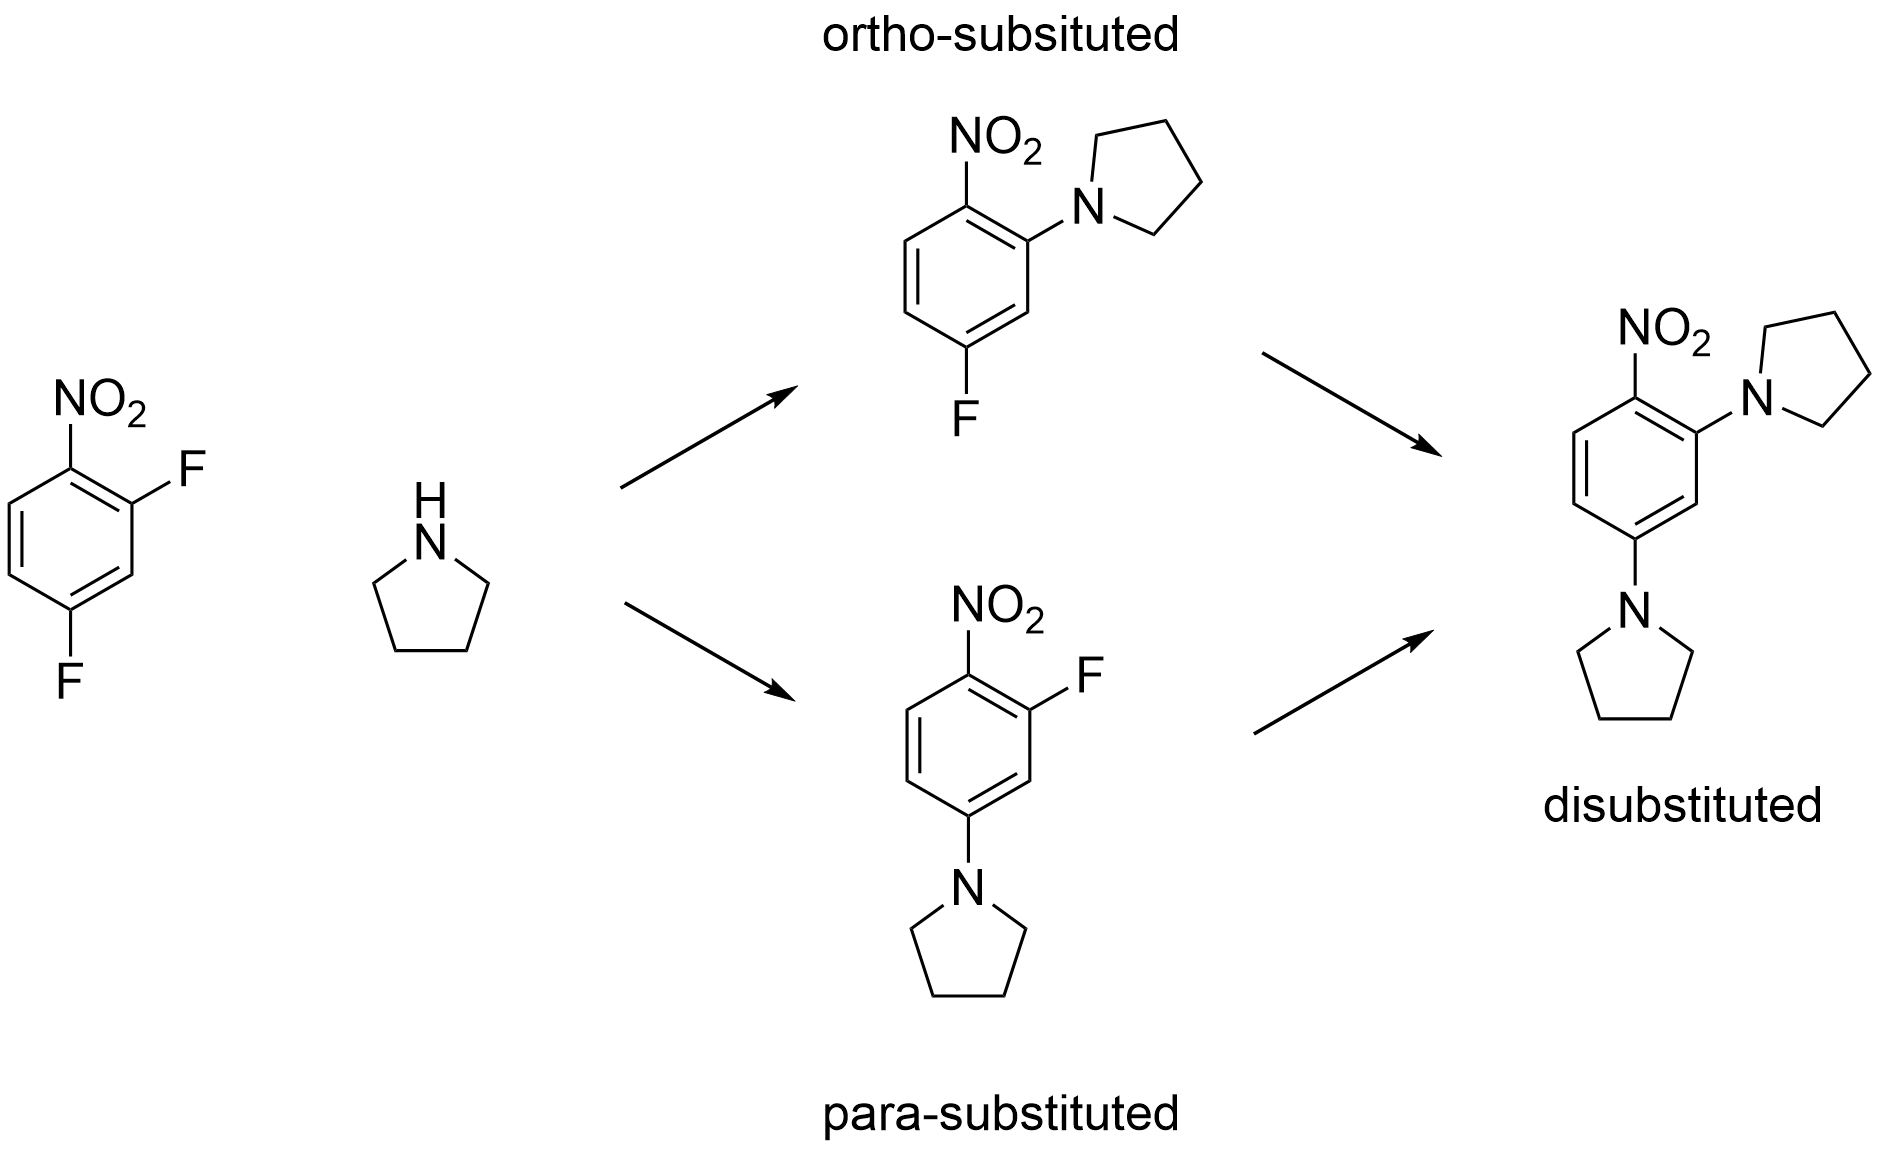

Rather than altering these things one-by-one, you are going to use a technique called Design of Experiments to figure out the optimal reaction conditions. Your task is to maximise the amount of ortho substituted product formed and to minimise the amount of para-product and starting material.

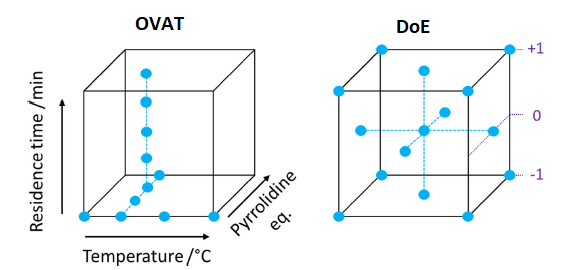

There are 5 factors that we have identified that can affect the outcome of this experiment:

1. residence time
2. temperature
3. equivalents of pyradine
4. concentration of 2,4-difluoronitrobenzene
5. concentration of triethylamine

We have chosen to keep the last two factors constant (the concentrations), so only have 3 factors. 

We used a *face-centered cubic* design, so should have had three levels for each factor (as shown in the figure above (right)).

The factors investigated and the levels chosen were:
1. residence time: 0.5, 2, 3.5 minutes
2. temperature: 30, 50, 70 $^\circ$C
3. equivalents of pyrrolidine: 2, 6, 10

**If you used different levels to this, change the code when you plot the results.**


The output we wish to maximise is the amount of the *ortho*-product, whilst minimising the amount of impurities. This is an *opimisation problem*.

**In the box below, make sure that the name of the xlsx file matches your file.**

In [2]:
df = pd.read_excel("edited_original_data.xlsx")

The code in the box above loads in your excel file, which is the name in the brackets. It uses a *function* called `read_excel()`, which does exactly what it sounds like. This function comes from a module, which is a set of functions written by someone else that we can use. This module is called pandas, but if you look above we gave it the short name `pd`. 

This function reads your excel file into something called a *dataframe*, which is panda's version of a table. It is generally better to keep your results in a read-only excel file and only use python to manipulate them, so you don't accidentally delete any of your results. 

We have called this dataframe: `df`. 

Type `df` in the box below to have a look at your data.

In [3]:
df

,Run,Run order,Residence time /min,Temperature /°C,Pyrrolidine eq.,SM /%,ortho /%,para /%,di /%
0,N1,3,0.5,30,2,79.7,20.3,0.0,0.0
1,N2,7,3.5,30,2,36.3,60.0,0.0,3.6
2,N3,12,2.0,30,6,29.6,66.4,0.0,4.1
3,N4,16,0.5,30,10,52.7,44.6,0.0,2.7
4,N5,2,3.5,30,10,10.9,83.9,0.0,5.2
5,N6,8,2.0,50,2,34.0,62.0,0.0,4.0
6,N7,13,0.5,50,6,41.2,55.3,0.0,3.5
7,N8,1,2.0,50,6,13.8,80.9,0.0,5.3
8,N9,11,2.0,50,6,14.9,79.9,0.0,5.2
9,N10,17,2.0,50,6,14.9,79.9,0.0,5.2


This should bring up a table that looks a lot like an excel table. 

The column headings should be labelled:  Residence time/min, Temperature /°C and Pyrrolidine eq. SM/%, ortho /%, para /% and di /%. 

If there are any NaN terms, go back to your excel document, copy it sideways and make sure that there are no gaps or empty rows.

### Setting up the inputs

First we make two new dataframes:

1. inputs to the model
2. responses given by the model

The code below will do this for you if you have correctly named the columns.

Here we rename the columns of the inputs and responses.

**Make sure that if you have used different column headings that you change the names of the column headings to your own**

In [4]:
# this makes a new dataframe called inputs
inputs = pd.DataFrame({'Time': df['Residence time /min'],
                                   'Temp': df['Temperature /°C'],
                                   'Eq': df['Pyrrolidine eq.']})
# this makes a new dataframe called responses
responses = pd.DataFrame({'ortho': df['ortho /%'],
                        'para': df['para /%'],
                        'di': df['di /%']})

# 0. DoENUT: Design of Experiments Numerical Utility Toolkit 

There are a few proprietary programs that will help you choose and set up a design, Modde is one, and you will likely come across it if you got to work in industry. 

Here we will use an open-source toolkit called DoENUT which can help you do the data analysis for a DoE experiment. 

Like pandas, DoENUT is a module of python functions. We use it thus:
`doenut.dunk()`, which tells python to go to the doenut module and find the function called `dunk`.

# 1a. Look at the data: inputs and responses

Lets have a look at inputs and features. Type the word `inputs` and `responses` into the two boxes below to see what is in these dataframes

In [5]:
inputs


,Time,Temp,Eq
0,0.5,30,2
1,3.5,30,2
2,2.0,30,6
3,0.5,30,10
4,3.5,30,10
5,2.0,50,2
6,0.5,50,6
7,2.0,50,6
8,2.0,50,6
9,2.0,50,6


In [6]:
responses

,ortho,para,di
0,20.3,0.0,0.0
1,60.0,0.0,3.6
2,66.4,0.0,4.1
3,44.6,0.0,2.7
4,83.9,0.0,5.2
5,62.0,0.0,4.0
6,55.3,0.0,3.5
7,80.9,0.0,5.3
8,79.9,0.0,5.2
9,79.9,0.0,5.2


# 1b: Look at the data: replicate plot

The first thing any good scientist does when starting data analysis is to sanity check the data by looking at it. 

We start by plotting the experiment number against the response for ortho (this is the yield of the ortho product). If you ran your experiments in a randomized order, then there should be no pattern in this plot of the results. If there is a pattern (and you randomized the run order) then there is a time-related bias in your results. This is an error. 

Also, you ideally want a large spread of values for your yeild to allow the program to build a good model. 

Finally, you want to check that your experimental methodology is correct, so you should have repeated some experiments, these are called replicates. If you have run some, the replicate experiments are plotted in red and should be close to each other (only the first set of replicates will be found). 

To plot the replicate plot we use the `doenut` function `replicate_plot` and we must give it the input dataframe (called `inputs`), the response dataframe (called `responses`) and the key which is the column label for the response we want to plot. `ortho` in this instance. 

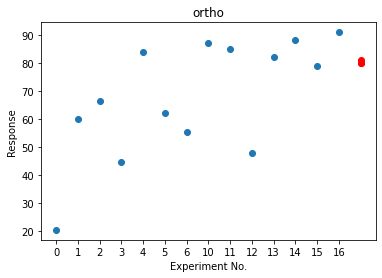

In [7]:
doenut.replicate_plot(inputs, responses, key="ortho")

# 3. Fit a simple model

Now that we know that the data is good, we shall build our first model!

A model relates input factors to output responses.
$$
inputs \rightarrow model \rightarrow outputs
$$

!!TODO - copy across stuff from the PhD notebooks

We shall start with a very simple model using only the three input factors:
1. Time: `inputs['Time']`, $t$
2. Temp: `inputs['Temp']`, $T$
3. Eq: `inputs['Eq']`, $Eq$

The code below will fit a model for the yeild of the ortho product `responses['ortho']` and gives you the *correlation correficiant* $R^2$. 

The model fitted below is this:
$$
y_{ortho} = \beta_0 + \beta_1 t + \beta_2 T + \beta_2 Eq
$$

In [8]:
original_model, inputs_used, original_model_R2, predictions = doenut.train_model(
    inputs, 
    responses['ortho'], 
    test_responses=None,
    do_scaling_here=False,
    fit_intercept=True,
    verbose=True)

R squared for this model is 0.827


The $R^2$ above might well be a good value, but that only tells us that the model is good at fitting the data, it doesn't tell us if the if we have trained a good model for predicting new data.

This function allows us to plot the measured response (what you measured in the flow experiment) against the response predicted from the model you just trained.

You may notice that your data seems to follow a curve rather than a straight line. This implies that there are interaction effects that we need to include in the model.

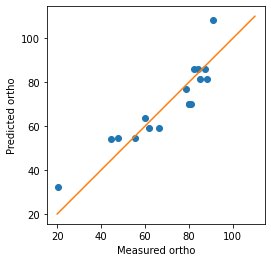

In [9]:
doenut.plot_observed_vs_predicted(responses['ortho'], 
                               predictions,
                               range_x=[],
                               label='ortho')

The following two functions will use the model that you just trained to predict where in chemical space we will find the optimum for the otho yeild, i.e. what values of Time, Temp and Eq will give us the highest yeild.

Don't worry about `my_function` right now, later you will write your function instead.

You may need to set the x_limits (minimum and maximum of the Time period you tested), y_limits (minimum and maximum of the temperature you tested). 

The constant is Eq in this graph, so this value is kept constant in each subfigure.

<Figure size 1440x864 with 0 Axes>

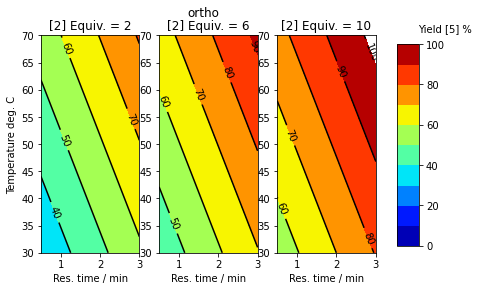

In [10]:
def my_function(df_1):
    """This function is for including the extra terms in your model
    This model has no extra terms so is an empty function"""
    pass
    return df_1

doenut.four_D_contour_plot(
    unscaled_model=original_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function,
    fig_label='ortho',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=11,
    z_limits=[0,100])

This model hasn't included interaction effects. One of the great things about doing DoE experimentation is that we can pick up the effect of interactions with only a few experiments, so lets see what interactions effects this system has.

You should see straight lines in the graph above, as we only have terms of the format $x$, $y$, $z$, below we will add in the cross and square terms

# Saturated model

The inputs to the model are called $features$, these include the input factors you've already used, but they can also include features that you can create from your inputs. 

For example, for a system with 3 input factors, $x_1$, $x_2$ and $x_3$ we could create a model like this:

!!! NTS add more details here

$y = \beta_0 + \beta_1  x_1 + \beta_2  x_2 + \beta_3 x_1  x_2 + \beta_4  x_1^2 + \beta_5  x_2^2$

We don't know the underlying equation (the model), so we do not know the values of the $\beta$, this is what we are going to learn from the data.

You may noticed that we could keep going, we could have highers powers (e.g. $\beta_i  x_a^3$ or $\beta_j  x_a^3  x_b^2$ etc). We make the *assumption* that this system is not that complicated, so we will not consider any terms with a power higher than 2, i.e. we are setting all other possible $\beta$ values to 0. In this feild the terms we add are called *polynomial features* and thus you can describe this process and only considering polynomial features up to power 2. 

A *saturated model* is one with all the polynomial features (up to our desired power) included. The model written above is a saturated model for two inputs and one output. 

Terms of the format $x_j^2$ are called *square terms* and show second order effects in the main term.

Terms of the format $x_i x_j$ are called *interaction terms*, and these show the interaction between the inputs $x_i$ and $x_j$. 

Both are very importent for understanding the complexity of the system and we are using [multiple factor at a time] experimentation to discover these.


**Task 1.** 

**Complete the a saturated model with polynomial features up to power 2 for a system with 3 inputs $x_1$, $x_2$ and $x_3$ in the box below. (You can see how I formatted the algebra by hitting return on the box above).**

$y = \beta_0 + \beta_1 x_1 + ...$

The model we will build does not know algebra, so we have to give it each of these polynomial features as well. We will later fit the model to these features and figure out which ones are significant. 

To do this we simply add the new terms (features) to the input dataframe. 

To add a column to a dataframe we use the following construction:
`dataframe['name of new column'] = name_of_data_to_be_added`

In this case, we use something like this:
`inputs['Time*2'] = inputs['Time']*inputs['Time']`

**Task 2.**

**Add the polynomial features to the dataframe in the box below, the first one is done for you:**

In [11]:
inputs['Time*2']= inputs['Time']*inputs['Time']
inputs['Temp*2']= inputs['Temp']*inputs['Temp']
inputs['Eq*2']= inputs['Eq']*inputs['Eq']
inputs['Time*Temp']= inputs['Time']*inputs['Temp']
inputs['Time*Eq']= inputs['Temp']*inputs['Eq']
inputs['Temp*Eq']= inputs['Temp']*inputs['Eq']

In [12]:
# This code is a test, if you get an error go back to task 2.
if not len(inputs.columns) == 9:
    print(f'Inputs has only {len(inputs.columns)} features')
    print('Error! Inputs should have 9 features')
    print('Go back to task 2 and try again!')

# this code will print out inputs so you can have a look at it.
inputs

,Time,Temp,Eq,Time*2,Temp*2,Eq*2,Time*Temp,Time*Eq,Temp*Eq
0,0.5,30,2,0.25,900,4,15.0,60,60
1,3.5,30,2,12.25,900,4,105.0,60,60
2,2.0,30,6,4.00,900,36,60.0,180,180
3,0.5,30,10,0.25,900,100,15.0,300,300
4,3.5,30,10,12.25,900,100,105.0,300,300
5,2.0,50,2,4.00,2500,4,100.0,100,100
6,0.5,50,6,0.25,2500,36,25.0,300,300
7,2.0,50,6,4.00,2500,36,100.0,300,300
8,2.0,50,6,4.00,2500,36,100.0,300,300
9,2.0,50,6,4.00,2500,36,100.0,300,300


## Training the saturated model

Now we train the saturated model using a different function that will calculate $Q^2$ which is a measure of how good the model is at predicting on unseen/new data. We want a predictive model, rather than one that jsut describes the data, as we want it to predict the conditions for maximum yeild, not just tell us what our yield was!

To get new data, we could go back to the lab (Yay!) or instead we can use our data. 

We use the *leave one out validation* method (yes, that is the technical term!). We take a single point out of our dataset, train the model on the rest and then see how well that model does at predicting the missing point. We then repeat, leaving out a different point until all points have been excluded. 

For each model we trained we will have gotten a different solution with different coordinates. To get the final model, the coefficients are averaged to give an averaged model. This one is a saturated model as it contains all the possible features. 

!!! To do, explain was Q2 is in here
!!! Could get the studetns to calculate R2 or Q2 themselves, but it might be too much in the time

Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.962	Ave. Error = 0.061
Left out data point 1:	R2 = 0.978	Ave. Error = 0.305
Left out data point 2:	R2 = 0.978	Ave. Error = 0.27
Left out data point 3:	R2 = 0.976	Ave. Error = 0.122
Left out data point 4:	R2 = 0.977	Ave. Error = -0.854
Left out data point 5:	R2 = 0.978	Ave. Error = -1.48
Left out data point 6:	R2 = 0.978	Ave. Error = -1.21
Left out data point 7:	R2 = 0.978	Ave. Error = 1.69
Left out data point 10:	R2 = 0.977	Ave. Error = -0.135
Left out data point 11:	R2 = 0.977	Ave. Error = 0.135
Left out data point 12:	R2 = 0.992	Ave. Error = -15.9
Left out data point 13:	R2 = 0.996	Ave. Error = 17.6
Left out data point 14:	R2 = 0.977	Ave. Error = -1.62
Left out data point 15:	R2 = 0.995	Ave. Error = 17.4
Left out data point 16:	R2 = 0.994	Ave. Error = -16.8
R2 overall is 0.979
Mean of test set: 68.9
Mean being used: 70.19411764705882
Sum of squares of the residuals (explained variance) is 1158.5441

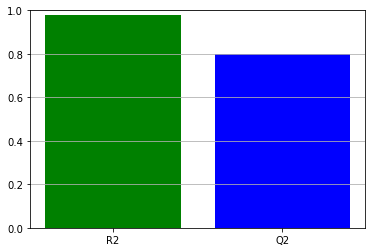

In [13]:
saturated_model, predictions, ground_truth, saturated_coeffs, R2s, R2, Q2 = doenut.calc_averaged_model(
    inputs, 
    responses[['ortho']], 
    key='ortho',
    drop_duplicates=True,
    use_scaled_inputs=True,
    fit_intercept=True,
    do_scaling_here=True)

### Coefficient plot

Now we have a trained model we can look at the coefficients using the `coeff_plot` function as below. These coefficients are the $\beta_1$ to $\beta_9$ that go with the features input into the model (and are labelled such in the graph below). 

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[ 20.26701456  10.36766911  12.92777308 -15.823993    -4.19574105
 -11.59883032  -3.70149753  -0.95964751  -0.95964751]
std
['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']


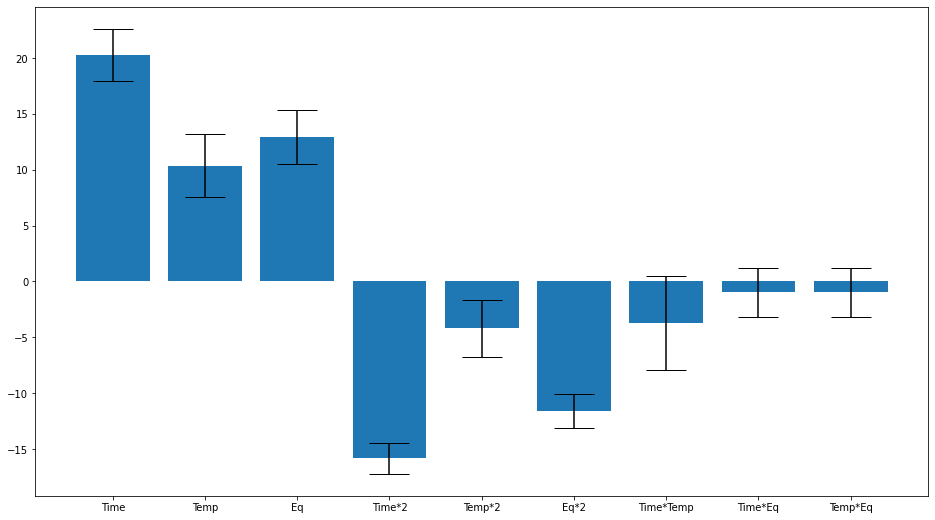

In [14]:
doenut.coeff_plot(saturated_coeffs, 
           labels=['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq'], 
           errors='std',
           normalise=True)

## Changing the model

!!! To do, explain about parsimonious models

We want to make our final model as simple as possible, but no simpler. We do this by removing insignificant terms

!! add in overfitting

!!! Todo explain how you tell. etc.

In the example below I have removed the smallest insignificant term, term number 8, by chaning `input_selector`. 

Input terms are ['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input Responses are ['ortho', 'para', 'di']

Selected Response is ortho
Selected input terms:	['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2']
Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.932	Ave. Error = -8.79
Left out data point 1:	R2 = 0.956	Ave. Error = 5.37
Left out data point 2:	R2 = 0.954	Ave. Error = 0.27
Left out data point 3:	R2 = 0.952	Ave. Error = -5.12
Left out data point 4:	R2 = 0.959	Ave. Error = 8.34
Left out data point 5:	R2 = 0.954	Ave. Error = -1.49
Left out data point 6:	R2 = 0.953	Ave. Error = -1.22
Left out data point 7:	R2 = 0.953	Ave. Error = 1.69
Left out data point 10:	R2 = 0.951	Ave. Error = -0.135
Left out data point 11:	R2 = 0.952	Ave. Error = 0.135
Left out data point 12:	R2 = 0.95	Ave. Error = -0.208
Left out data point 13:	R2 = 0.955	Ave. Error = 4.78
Left out data point 14:	R2 = 0.951	Ave. Error = -1.62
Left o

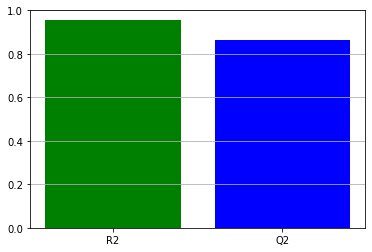

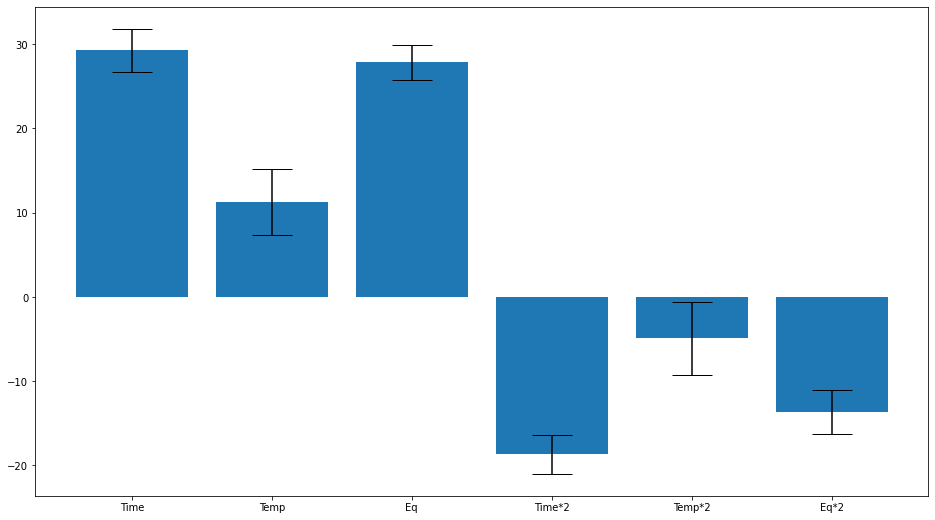

In [33]:
this_model, R2, temp_tuple = doenut.calulate_R2_and_Q2_for_models(
                        inputs, 
                        responses, 
                        input_selector=[0,1,2,3,4,5], 
                        response_selector=[0],
                        use_scaled_inputs=True,
                        do_scaling_here=True)
new_model, predictions, ground_truth, coeffs, R2s, R2, Q2 = temp_tuple

Lets look at the predictions from this model. 

We need to tell the `four_D_contour_plot` function which terms over and above the 3 base terms are in the model. 

This is done by writing a function. You need to copy in the format used in task one. For example, for the model above, use:

`def my_function(df_1):
    df_1['Time*2'] = df_1['Time']*df_1['Time']
    df_1['Temp*2'] = df_1['Temp']*df_1['Temp']
    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
    df_1['Time*Temp'] = df_1['Time']*df_1['Temp']
    df_1['Time*Eq'] = df_1['Time']*df_1['Eq']
    return df_1`


In [34]:
def my_function(df_1):
    df_1['Time*2'] = df_1['Time']*df_1['Time']
    df_1['Temp*2'] = df_1['Temp']*df_1['Temp']
    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
  #df_1['Time*Temp'] = df_1['Time']*df_1['Temp']
 #   df_1['Time*Eq'] = df_1['Time']*df_1['Eq']
    return df_1

<Figure size 1440x864 with 0 Axes>

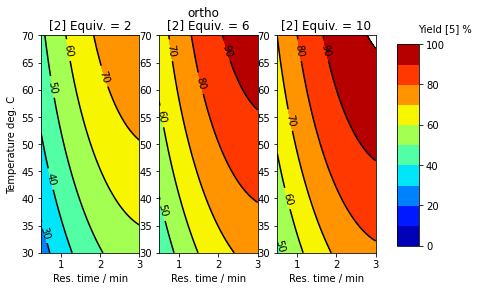

In [35]:
doenut.four_D_contour_plot(
    unscaled_model=this_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function,
    fig_label='ortho',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=11,
    z_limits=[0,100])

## Task 2: Find the best parsimonious model

**Keep removing insignificant terms and keep note of the R2 and Q2 values. Call your final model: ortho_model.**

**Write the function `my_function` for that model to get the prediction plots for your final model.**

**Important:**
We want something called a hierarchical model, so you cannot have higher order terms without having the relevant lower order term. So do not remove Time, Temp or Eq terms, even if they become insigificant if you are keeping in the higher order terms (e.g. do not remove Time, if you have `Time*Eq`, `Time*Temp` or `Time*2` in your model.


Input terms are ['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input Responses are ['ortho', 'para', 'di']

Selected Response is ortho
Selected input terms:	['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.962	Ave. Error = 0.061
Left out data point 1:	R2 = 0.978	Ave. Error = 0.305
Left out data point 2:	R2 = 0.978	Ave. Error = 0.27
Left out data point 3:	R2 = 0.976	Ave. Error = 0.122
Left out data point 4:	R2 = 0.977	Ave. Error = -0.854
Left out data point 5:	R2 = 0.978	Ave. Error = -1.48
Left out data point 6:	R2 = 0.978	Ave. Error = -1.21
Left out data point 7:	R2 = 0.978	Ave. Error = 1.69
Left out data point 10:	R2 = 0.977	Ave. Error = -0.135
Left out data point 11:	R2 = 0.977	Ave. Error = 0.135
Left out data point 12:	R2 = 0.992	Ave. Error = -15.9
Left out data point 13:	R2 = 0.996	Ave. Error = 17.6
Left out data point 14

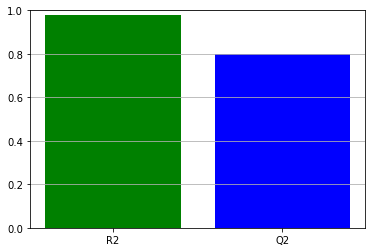

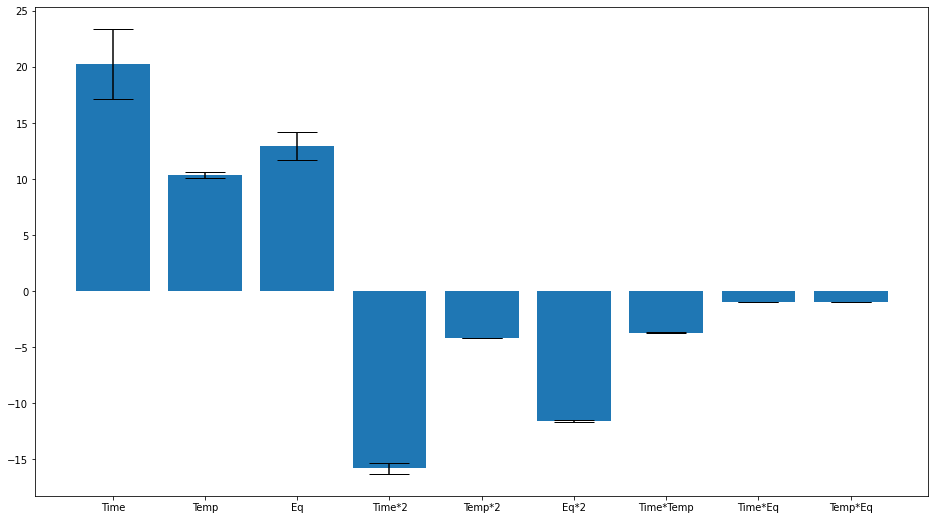

In [23]:
ortho_model, R2, temp_tuple = doenut.calulate_R2_and_Q2_for_models(
                        inputs, 
                        responses, 
                        input_selector=[0,1,2,3,4,5,6,7,8], 
                        response_selector=[0],
                        use_scaled_inputs=False,
                        do_scaling_here=False)

### Best fit plot
This should be better than the original model

In [24]:
predictions = ortho_model.predict(inputs[['Time', 'Temp', 'Eq', 'Time*2', 'Eq*2']])
doenut.plot_observed_vs_predicted(responses['ortho'], 
                               predictions,
                               range_x=[],
                               label='ortho')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9 is different from 5)

In [25]:
def my_function(df_1):
    df_1['Time*2'] = df_1['Time']*df_1['Time']
    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
    return df_1

doenut.four_D_contour_plot(
    unscaled_model=ortho_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function,
    fig_label='ortho',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=21,
    z_limits=[0,100])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9 is different from 5)

In [ ]:
def my_function(df_1):
    df_1['Time*2'] = df_1['Time']*df_1['Time']
    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
    return df_1

doenut.four_D_contour_plot(
    unscaled_model=ortho_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,7.5], 
    y_limits=[0,70], 
    constants=[8,12,16], 
    n_points=60,
    my_function=my_function,
    fig_label='',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='Equiv.',
    z_label = 'Yield %',
    cmap='jet',
    num_of_z_levels=11,
    z_limits=[0,100])

# Data analysis

You've now built a nice model that both fits and predicts your ortho data, now do the same with the other two responses:

`responses['para']`
`responses['bis']`

In [ ]:
responses.columns

# Bis

Should this be Bis?

Input terms are ['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input Responses are ['ortho', 'para', 'di']

Selected Response is di
Selected input terms:	['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.946	Ave. Error = -0.958
Left out data point 1:	R2 = 0.971	Ave. Error = 0.72
Left out data point 2:	R2 = 0.968	Ave. Error = 0.215
Left out data point 3:	R2 = 0.971	Ave. Error = 0.812
Left out data point 4:	R2 = 0.973	Ave. Error = -0.866
Left out data point 5:	R2 = 0.967	Ave. Error = 0.125
Left out data point 6:	R2 = 0.967	Ave. Error = -0.01
Left out data point 7:	R2 = 0.967	Ave. Error = 0.025
Left out data point 10:	R2 = 0.966	Ave. Error = -0.01
Left out data point 11:	R2 = 0.966	Ave. Error = -0.145
Left out data point 12:	R2 = 0.984	Ave. Error = -1.42
Left out data point 13:	R2 = 0.986	Ave. Error = 1.48
Left out data point 14:

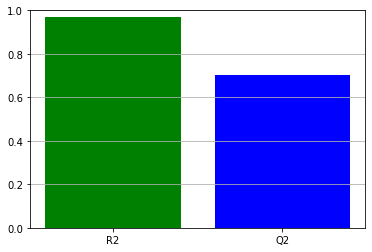

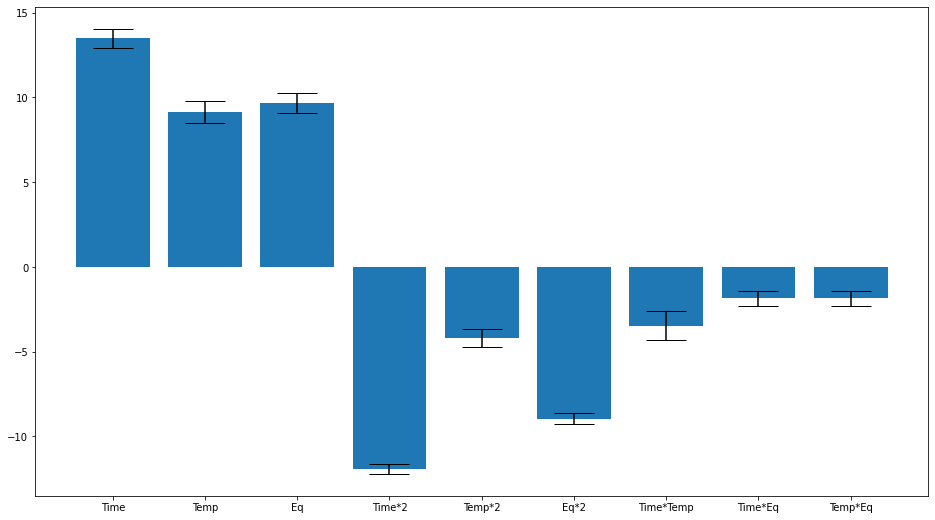

In [26]:
bis_model, R2, temp_tuple = doenut.calulate_R2_and_Q2_for_models(
                        inputs, 
                        responses, 
                        input_selector=[0,1,2,3,4,5,6,7,8], 
                        response_selector=[2],
                        fit_intercept=True,
                        use_scaled_inputs=True,
                        do_scaling_here=True)

### Best fit plot
This should be better than the original model

In [27]:
predictions = bis_model.predict(inputs)
doenut.plot_observed_vs_predicted(responses['bis'], 
                               predictions,
                               range_x=[],
                               label='bis')

KeyError: 'bis'

<Figure size 1440x864 with 0 Axes>

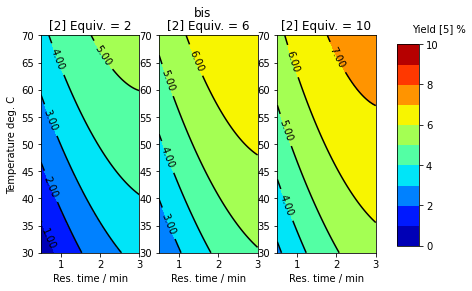

In [28]:
def my_function(df_1):
    df_1['Time*2'] = df_1['Time']*df_1['Time']
    df_1['Temp*2'] = df_1['Temp']*df_1['Temp']
    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
    df_1['Time*Temp'] = df_1['Time']*df_1['Temp']
    df_1['Time*Eq'] = df_1['Time']*df_1['Eq']
    df_1['Temp*Eq'] = df_1['Temp']*df_1['Eq']
    return df_1

doenut.four_D_contour_plot(
    unscaled_model=bis_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function,
    fig_label='bis',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=11,
    z_limits=[0,10])

## Para model

Input terms are ['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Eq*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input Responses are ['ortho', 'para', 'di']

Selected Response is para
Selected input terms:	['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']
Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.781	Ave. Error = -0.138
Left out data point 1:	R2 = 0.785	Ave. Error = 0.294
Left out data point 2:	R2 = 0.786	Ave. Error = -0.27
Left out data point 3:	R2 = 0.78	Ave. Error = -0.0638
Left out data point 4:	R2 = 0.787	Ave. Error = 0.368
Left out data point 5:	R2 = 0.782	Ave. Error = 0.144
Left out data point 6:	R2 = 0.808	Ave. Error = 0.57
Left out data point 7:	R2 = 0.785	Ave. Error = -0.212
Left out data point 10:	R2 = 0.797	Ave. Error = -0.445
Left out data point 11:	R2 = 0.783	Ave. Error = -0.0111
Left out data point 12:	R2 = 0.847	Ave. Error = 1.14
Left out data point 13:	R2 = 0.905	Ave. Error = -1.55
Left out data point 14:	R2

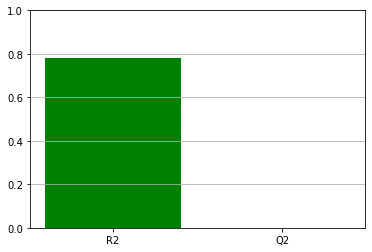

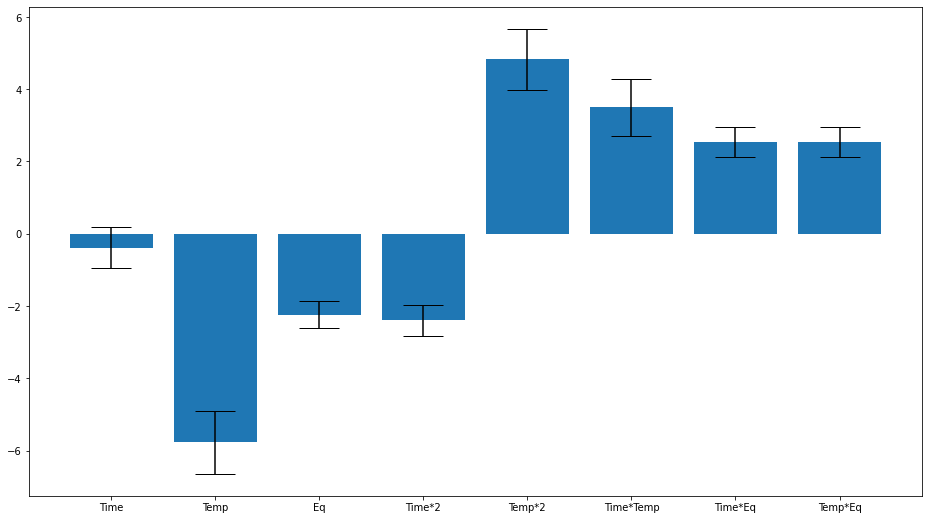

In [29]:
para_model, R2, temp_tuple = doenut.calulate_R2_and_Q2_for_models(
                        inputs, 
                        responses, 
                        input_selector=[0,1,2,3,4,6,7,8], 
                        response_selector=[1],
                        use_scaled_inputs=True,
                        fit_intercept=True,
                        do_scaling_here=True)

### Best fit plot
This should be better than the original model

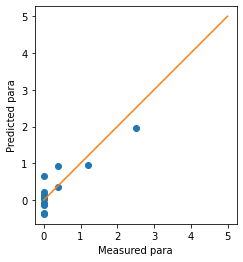

In [30]:
predictions = para_model.predict(inputs[['Time', 'Temp', 'Eq', 'Time*2', 'Temp*2', 'Time*Temp', 'Time*Eq', 'Temp*Eq']])
doenut.plot_observed_vs_predicted(responses['para'], 
                               predictions,
                               range_x=[0,5],
                               label='para')

<Figure size 1440x864 with 0 Axes>

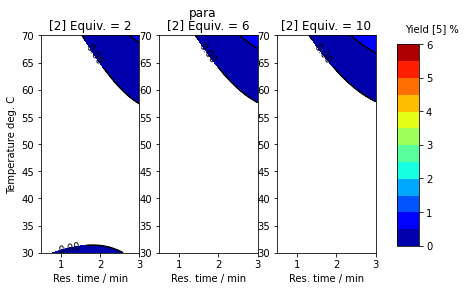

In [31]:
def my_function(df_1):
    df_1['Time*2'] = df_1['Time']*df_1['Time']
    df_1['Temp*2'] = df_1['Temp']*df_1['Temp']
    df_1['Time*Temp'] = df_1['Time']*df_1['Temp']
    df_1['Time*Eq'] = df_1['Time']*df_1['Eq']
    df_1['Temp*Eq'] = df_1['Temp']*df_1['Eq']
    return df_1

doenut.four_D_contour_plot(
    unscaled_model=para_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function,
    fig_label='para',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=13,
    z_limits=[0,6])

<Figure size 1440x864 with 0 Axes>

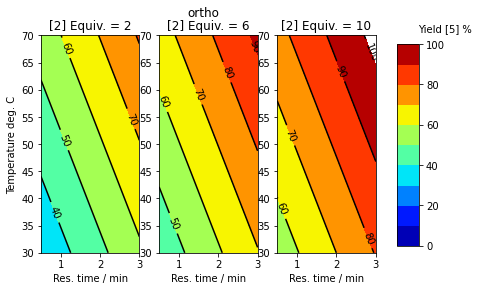

In [32]:
def my_function(df_1):
    """This function is for including the extra terms in your model
    This model has no extra terms so is an empty function"""
    pass
    return df_1

doenut.four_D_contour_plot(
    unscaled_model=original_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function,
    fig_label='ortho',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=11,
    z_limits=[0,100])